In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns

from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
import pydot

from scipy import stats
from sklearn.preprocessing import PowerTransformer

import io
import matplotlib.image as mpimg

/home/zj448/miniconda3/envs/causal/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
df=pd.read_csv('marsset_data_full.csv')
df

,number,class,Hr,a,e,inc,c,deltac,class2
0,1,cla,6.85,43.72,0.05,7.75,22.23,6.16,cla
1,2,cla,7.17,43.86,0.10,31.67,20.64,9.66,cla
2,3,cla,6.23,43.89,0.13,7.35,31.62,10.39,cla
3,4,cla,7.45,42.18,0.05,8.03,31.50,2.50,cla
4,5,cla,7.28,42.70,0.08,13.19,29.57,9.68,cla
...,...,...,...,...,...,...,...,...,...
224,225,det,7.22,61.79,0.39,5.79,9.88,2.29,det
225,226,det,7.25,55.30,0.29,22.46,16.60,2.33,det
226,227,det,7.20,46.16,0.49,44.89,14.30,0.80,det
227,228,det,6.42,150.15,0.73,33.54,18.50,1.00,det


In [16]:
classes=np.unique(df['class2'])
classes

array(['cen', 'cla', 'det', 'res', 'sca'], dtype=object)

In [17]:
rename_dict = {'cen':'Centaurs','cla':'Classicals','det':'Detached','res':'Resonant','sca':'Scattered'}
df['class2'] = df['class2'].replace(rename_dict)
classes=np.unique(df['class2'])

In [18]:
df=df[['a','e','inc','c','class2']]

In [19]:
# rename columns to a,e,i,Class
df.rename(columns={'a': 'a', 'e': 'e', 'inc': 'i', 'c': 'c', 'class2': 'Class'}, inplace=True)
df.to_csv('Col.csv', index=False)

/tmp/ipykernel_3027147/1019444993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'a': 'a', 'e': 'e', 'inc': 'i', 'c': 'c', 'class2': 'Class'}, inplace=True)


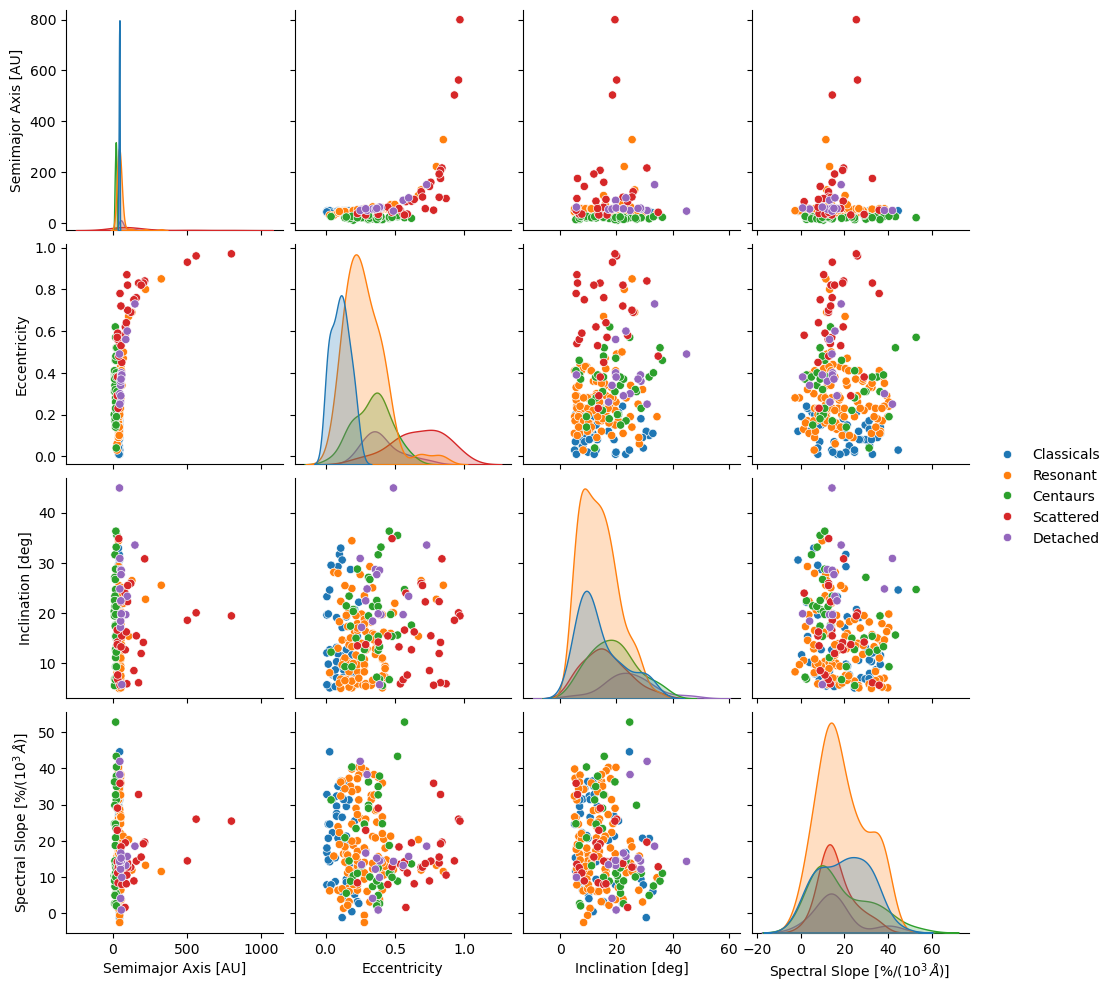

In [7]:
scatter_labels = ['Semimajor Axis [AU]', 'Eccentricity', 'Inclination [deg]', r'Spectral Slope $[\%/(10^3\,\AA)]$']

pairplot = sns.pairplot(df, hue="class2", diag_kind='kde', palette="tab10")

# Remove the legend title
pairplot._legend.set_title(None)

# Change the y-axis labels
for i, label in enumerate(scatter_labels):
    pairplot.axes[i, 0].set_ylabel(label)

# Change the x-axis labels
for i, label in enumerate(scatter_labels):
    pairplot.axes[-1, i].set_xlabel(label)
plt.show()

In [8]:
labels_list = [r'$\text{a}$',r'$\text{e}$', r'$\text{inc}$', r'$\text{color}$']

In [9]:
def causallearn_to_pydot(g,title=None,fontsize=25,dpi=500,latex_fontsize='xx-large',render_latex=True,labels_list=labels_list):

    # Render LaTeX to an image
    def render_latex_to_file(str, filepath):
        fig = plt.figure()
        fig = plt.figure(figsize=(0.01, 0.01))
        fig.text(0, 0, str, fontsize=latex_fontsize, ha='center', va='center')
        plt.axis('off')
        plt.savefig(filepath, bbox_inches='tight')
        plt.close(fig)

    if render_latex:
        for i,string in enumerate(labels_list):
            render_latex_to_file(string,'labels/label'+str(i)+'.png')

    #
    nodes = g.get_nodes()
    edges = g.get_graph_edges()

    pydot_g = pydot.Dot(graph_type="digraph")
    if dpi!=None:
        pydot_g.obj_dict["attributes"]["dpi"] = dpi

    for i, node in enumerate(nodes):
        node_name = node.get_name()
        pydot_g.add_node(pydot.Node(i, image='/home/zj448/causalTNOs/labels/label'+str(i)+'.png'
                                    ,label=""))

    def get_g_arrow_type(endpoint):
        if endpoint == Endpoint.TAIL:
            return 'none'
        elif endpoint == Endpoint.ARROW:
            return 'normal'
        elif endpoint == Endpoint.CIRCLE:
            return 'odot'
        else:
            raise NotImplementedError()
        
    for edge in edges:
        node1 = edge.get_node1()
        node2 = edge.get_node2()
        node1_id = nodes.index(node1)
        node2_id = nodes.index(node2)
        dot_edge = pydot.Edge(node1_id, node2_id, dir='both', arrowtail=get_g_arrow_type(edge.get_endpoint1()),
                                arrowhead=get_g_arrow_type(edge.get_endpoint2()))

        if Edge.Property.dd in edge.properties:
            dot_edge.obj_dict["attributes"]["color"] = "green3"

        if Edge.Property.nl in edge.properties:
            dot_edge.obj_dict["attributes"]["penwidth"] = 2.0

        pydot_g.add_edge(dot_edge)

    if title!=None:
        pydot_g.set_label(title)
        pydot_g.set_labelloc('t')
    pydot_g.set_fontsize(fontsize)
    pydot_g.set_fontname('Calibri')
    return pydot_g

# Transformed, Fisher-z

In [10]:
def transform_to_gaussian(x, method='auto'):
    """Transform data to be more Gaussian using specified method."""
    x_array = x.values if isinstance(x, pd.Series) else np.array(x)
    
    if method == 'yeo-johnson':
        pt = PowerTransformer(method='yeo-johnson')
        return pt.fit_transform(x_array.reshape(-1, 1)).ravel()
    
    elif method == 'rank':
        ranked_data = stats.rankdata(x_array)
        n = len(x_array)
        return stats.norm.ppf((ranked_data - 0.5) / n)
    
    elif method == 'auto':
        transformed = transform_to_gaussian(x_array, 'yeo-johnson')
        if stats.shapiro(transformed)[1] < 0.05:
            transformed = transform_to_gaussian(transformed, 'rank')
        return transformed
    
    else:
        raise ValueError("method must be 'yeo-johnson', 'rank', or 'auto'")

def transform_with_lower_threshold(x, threshold=-1, steepness=2):
    x_init = transform_to_gaussian(x, method='auto')
    weight = 0.7 * (1 + np.tanh(steepness * (x_init + threshold)))
    transformed = x_init * weight
    return stats.zscore(transformed)

def transform_with_upper_threshold(x, threshold=1, steepness=3):
    x_init = transform_to_gaussian(x, method='auto')
    weight = 0.5 * (1 - np.tanh(steepness * (x_init - threshold))) + 0.1
    transformed = x_init * weight
    return stats.zscore(transformed)

def transform_with_upper_threshold_e(x, threshold=1.3, steepness=1):
    x_init = transform_to_gaussian(x, method='auto')
    weight = 0.9 * (1 - np.tanh(steepness * (x_init - threshold))) + 0.3
    transformed = x_init * weight
    return stats.zscore(transformed)


In [11]:
# Apply transformations
transformed_df = df.copy()

# Transform inclination
transformed_df['inc'] = transform_to_gaussian(df['inc'], method='auto')

# Transform eccentricity
transformed_df['e'] = transform_with_upper_threshold_e(transformed_df['e'])
transformed_df['e'] = transform_to_gaussian(transformed_df['e'], method='auto')

# Transform semimajor axis
transformed_df['a'] = transform_with_lower_threshold(df['a'])
transformed_df['a'] = transform_with_upper_threshold(transformed_df['a'])
transformed_df['a'] = transform_to_gaussian(transformed_df['a'], method='auto')

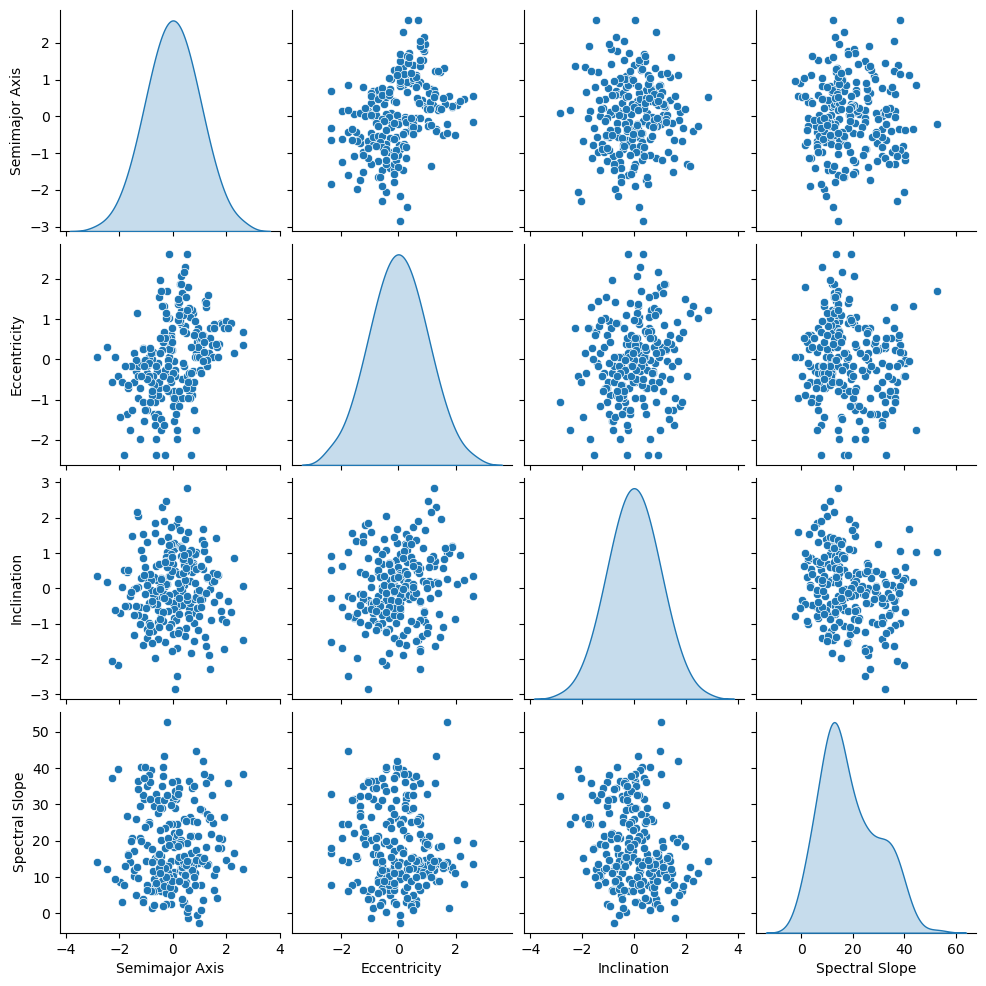

In [12]:
# Create pairplot
scatter_labels = ['Semimajor Axis', 'Eccentricity', 'Inclination', 'Spectral Slope']
pairplot = sns.pairplot(transformed_df, diag_kind='kde')

# Change the y-axis labels
for i, label in enumerate(scatter_labels):
    pairplot.axes[i, 0].set_ylabel(label)

# Change the x-axis labels
for i, label in enumerate(scatter_labels):
    pairplot.axes[-1, i].set_xlabel(label)
plt.show()

Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 789.59it/s]

0 dep 1 | () with p-value 0.000000

0 ind 2 | () with p-value 0.750264

0 ind 3 | () with p-value 0.958426

1 dep 0 | () with p-value 0.000000

1 dep 2 | () with p-value 0.004821

1 ind 3 | () with p-value 0.091690

2 ind 0 | () with p-value 0.750264

2 dep 1 | () with p-value 0.004821

2 dep 3 | () with p-value 0.000642

3 ind 0 | () with p-value 0.958426

3 ind 1 | () with p-value 0.091690

3 dep 2 | () with p-value 0.000642

1 dep 0 | (2,) with p-value 0.000000

1 dep 2 | (0,) with p-value 0.003879

2 dep 1 | (3,) with p-value 0.012182

2 dep 3 | (1,) with p-value 0.001597

Orienting collider: X1 *-> X2 <-* X3
Orienting collider: X2 *-> X3 <-* X4
Orienting collider: X1 *-> X2 <-* X3
Orienting collider: X2 *-> X3 <-* X4


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

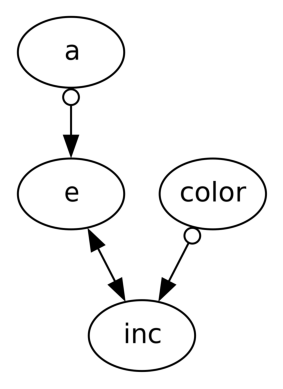

In [13]:
alpha=0.013
g, edges = fci(np.array(transformed_df[['a','e','inc','c']]),'fisherz',alpha=alpha,verbose=True,uc_rule=2)
pyd=causallearn_to_pydot(g,render_latex=True,dpi=500,latex_fontsize=70,labels_list=labels_list)

tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

# Untransformed, Fisher-z

Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 627.26it/s]


0 dep 1 | () with p-value 0.000000

0 ind 2 | () with p-value 0.143803

0 ind 3 | () with p-value 0.918242

1 dep 0 | () with p-value 0.000000

1 dep 2 | () with p-value 0.005290

1 ind 3 | () with p-value 0.211388

2 ind 0 | () with p-value 0.143803

2 dep 1 | () with p-value 0.005290

2 dep 3 | () with p-value 0.001430

3 ind 0 | () with p-value 0.918242

3 ind 1 | () with p-value 0.211388

3 dep 2 | () with p-value 0.001430

1 dep 0 | (2,) with p-value 0.000000

1 dep 2 | (0,) with p-value 0.017642

2 dep 1 | (3,) with p-value 0.009840

2 dep 3 | (1,) with p-value 0.002643

Orienting collider: X1 *-> X2 <-* X3
Orienting collider: X2 *-> X3 <-* X4
Orienting collider: X1 *-> X2 <-* X3
Orienting collider: X2 *-> X3 <-* X4


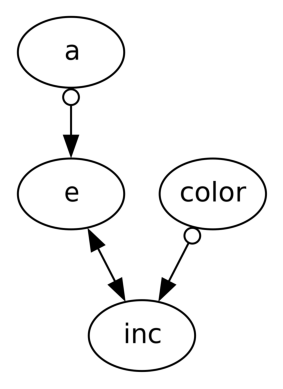

In [14]:
alpha=0.02
g, edges = fci(np.array(df[['a','e','inc','c']]),'fisherz',alpha=alpha,verbose=True,uc_rule=2)
pyd=causallearn_to_pydot(g,render_latex=False,dpi=500,latex_fontsize=70,labels_list=labels_list)

tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

# Untransformed, KCI

Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 245.23it/s]


0 dep 1 | () with p-value 0.000000

0 ind 2 | () with p-value 0.420744

0 ind 3 | () with p-value 0.488043

1 dep 0 | () with p-value 0.000000

1 dep 2 | () with p-value 0.085105

1 ind 3 | () with p-value 0.135326

2 ind 0 | () with p-value 0.420744

2 dep 1 | () with p-value 0.085105

2 dep 3 | () with p-value 0.009405

3 ind 0 | () with p-value 0.488043

3 ind 1 | () with p-value 0.135326

3 dep 2 | () with p-value 0.009405

1 dep 0 | (2,) with p-value 0.067835

1 dep 2 | (0,) with p-value 0.070081

2 dep 1 | (3,) with p-value 0.040643

2 dep 3 | (1,) with p-value 0.004260

Orienting collider: X1 *-> X2 <-* X3
Orienting collider: X2 *-> X3 <-* X4
Orienting collider: X1 *-> X2 <-* X3
Orienting collider: X2 *-> X3 <-* X4


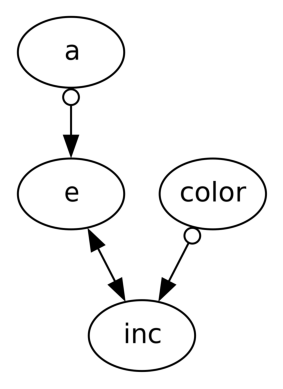

In [15]:
alpha=0.09
g, edges = fci(np.array(df[['a','e','inc','c']]),'kci',polyd=2, kernelX='Polynomial', kernelY='Polynomial', kernelZ='Polynomial',alpha=alpha,verbose=True,uc_rule=2)
pyd=causallearn_to_pydot(g,render_latex=False,dpi=500,latex_fontsize=70,labels_list=labels_list)

tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

# Leave one out for each population

Without Centaurs sample_size: 193 alpha: 0.225


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 322.01it/s]


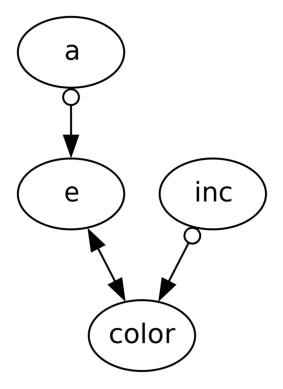

Without Classicals sample_size: 181 alpha: 0.05


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 669.56it/s]


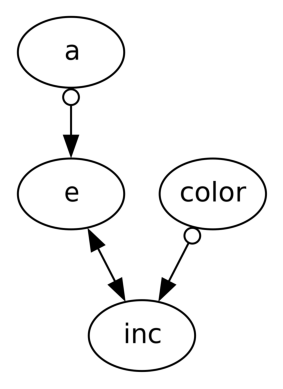

Without Detached sample_size: 214 alpha: 0.09


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 702.53it/s]


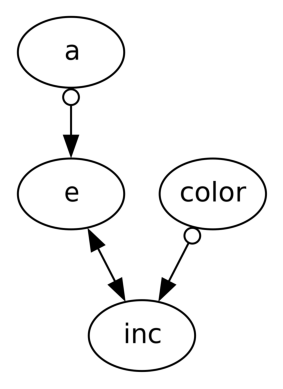

Without Resonant sample_size: 127 alpha: 0.11


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 639.55it/s]


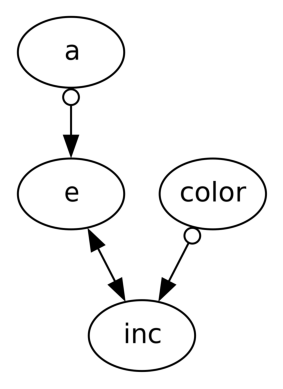

Without Scattered sample_size: 201 alpha: 0.01


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 658.11it/s]


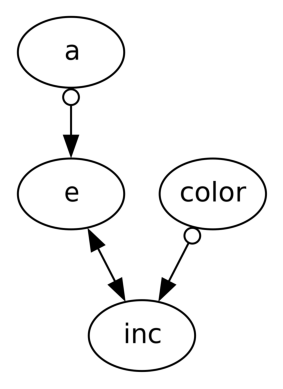

In [16]:
alpha=[0.225,0.05,0.09,0.11,0.01]
for i,class2 in enumerate(classes):
    print('Without',class2,'sample_size:',len(df[df['class2']!=class2]),'alpha:',alpha[i])
    df_no_res = df[df['class2']!=class2][['a','e','inc','c']]
    #g, edges = fci(np.array(df_no_res),'fisherz',alpha=alpha[i],verbose=True,uc_rule=2)
    if class2=='Centaurs':
        g, edges = fci(np.array(df_no_res),'kci',polyd=2, kernelX='Polynomial', kernelY='Polynomial', kernelZ='Polynomial',alpha=alpha[i],verbose=False,uc_rule=2)
    else:
        g, edges = fci(np.array(df_no_res),'fisherz',alpha=alpha[i],verbose=False,uc_rule=2)
    pyd=causallearn_to_pydot(g,render_latex=False,dpi=500,latex_fontsize=70,labels_list=labels_list)

    tmp_png = pyd.create_png(f="png")
    fp = io.BytesIO(tmp_png)
    img = mpimg.imread(fp, format='png')
    plt.axis('off')
    plt.imshow(img)
    plt.show()

# Sub-populations

Class: Centaurs sample_size: 36 alpha: 0.3


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 693.93it/s]


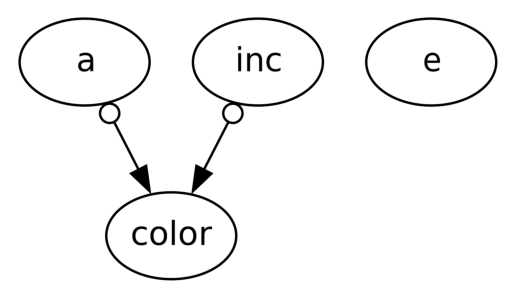

Class: Classicals sample_size: 48 alpha: 0.05


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 644.96it/s]


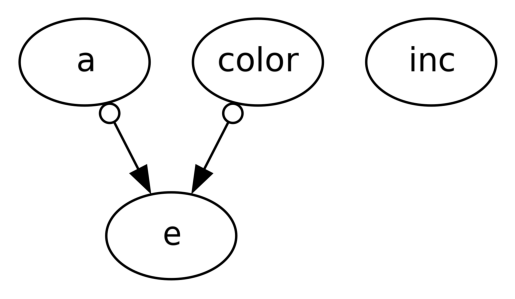

Class: Detached sample_size: 15 alpha: 0.4


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 470.74it/s]


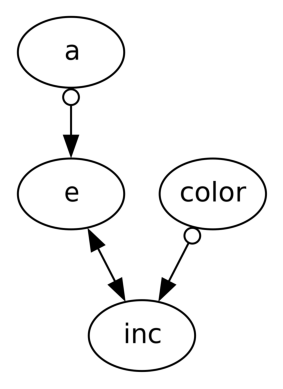

Class: Resonant sample_size: 102 alpha: 0.05


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 682.94it/s]


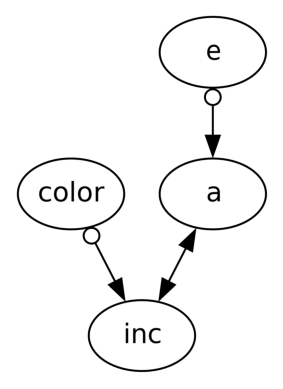

Class: Scattered sample_size: 28 alpha: 0.2


Depth=0, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 710.18it/s]


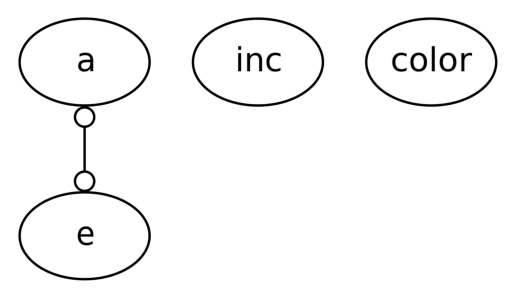

In [17]:
alpha=[0.3,0.05,0.4,0.05,0.2]
for i,class2 in enumerate(classes):
    print('Class:',class2,'sample_size:',len(df[df['class2']==class2]),'alpha:',alpha[i])
    df_class = df[df['class2']==class2][['a','e','inc','c']]
    g, edges = fci(np.array(df_class),'fisherz',alpha=alpha[i],verbose=False,uc_rule=2)
    pyd=causallearn_to_pydot(g,render_latex=False,dpi=500,latex_fontsize=70,labels_list=labels_list)

    tmp_png = pyd.create_png(f="png")
    fp = io.BytesIO(tmp_png)
    img = mpimg.imread(fp, format='png')
    plt.axis('off')
    plt.imshow(img)
    plt.show()